In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from collections import defaultdict

In [13]:
def files_to_infos(logdir, files):
    infos = []
    for file in files:
        print(file)
        rows = []
        with open(logdir + file) as f:
            lines = f.readlines()
            for l in lines:
                rows.append(json.loads(l))


        info = defaultdict(list)

        for row in rows:
                for k in ['mbps', 'enc', 'dec', 'enc_b', 'dec_b', 'delta_hist', 'input_hist', 'reconstruction_hist', 'current_k',
                        'latent_hist', 'rmse', 'mse', 'scaled_mse', 'input_mean', 'input_std', 'L0', 'L1', 'loss', 'dead_feature_prop', 'dead_latent_pct',
                        'experts_chosen_hist', 'dec_hist', 
                        'enc_grad_hist', 'dec_grad_hist', 'router_grad_hist', 'pre_grad_hist',
                        'pos_mask', 'tokens_per_second',
                        'position_mse', 'ma_count', 'massive_activations', 'variance_proportional_mse', "sum_mse",
                        "torch.cuda.memory_allocated", "torch.cuda.memory_reserved", "torch.cuda.max_memory_reserved", "cpu_percent", 
                        
                        ]:
                    if k in row:
                        info[k].append(row[k])

        for k, v in rows[0].items():
            if k in info:
                raise ValueError(f'key {k} already in info')
            info[k] = v

        info['file'] = file
        infos.append(info)
    return infos

In [14]:
starts = ['relu', 'topk']
# starts = ['flop-']


files = []
logdir = '../log/'
prefix = 'ViT-3mil_'

for file in os.listdir(logdir):
    for start in starts:
        if file.startswith(prefix + start):
            files.append(file)

print(len(files))
print(files)
infos = files_to_infos(logdir, files)

print(len(infos))

50
['ViT-3mil_relu-l1-5e-05_ccf308.jsonl', 'ViT-3mil_topkk-16-experts-128_359b08.jsonl', 'ViT-3mil_topkk-16-experts-32_2ad62b.jsonl', 'ViT-3mil_topkk-16-experts-8_62b60e.jsonl', 'ViT-3mil_topkk-32-experts-32_f085b4.jsonl', 'ViT-3mil_topkk-32-experts-16_9087ea.jsonl', 'ViT-3mil_topkk-16-experts-16_f9a602.jsonl', 'ViT-3mil_relu-l1-0.0001_ed4f74.jsonl', 'ViT-3mil_relu-l1-0.00011_e45ad3.jsonl', 'ViT-3mil_topkk-256-experts-8_c42a78.jsonl', 'ViT-3mil_topkk-128-experts-16_f1395b.jsonl', 'ViT-3mil_topkk-8-experts-8_fa5f99.jsonl', 'ViT-3mil_relu-l1-9e-05_f0477c.jsonl', 'ViT-3mil_topkk-64-experts-64_e9bdfb.jsonl', 'ViT-3mil_topkk-64-experts-8_3e556f.jsonl', 'ViT-3mil_topkk-8-experts-None_f2bbf8.jsonl', 'ViT-3mil_relu-l1-8e-05_81baeb.jsonl', 'ViT-3mil_topkk-8-experts-128_df2283.jsonl', 'ViT-3mil_topkk-8-experts-16_b795b6.jsonl', 'ViT-3mil_topkk-256-experts-16_2bf39b.jsonl', 'ViT-3mil_topkk-32-experts-4_cf67f6.jsonl', 'ViT-3mil_topkk-32-experts-2_693688.jsonl', 'ViT-3mil_topkk-64-experts-128_f61f3

ViT-3mil_topkk-8-experts-None_f2bbf8.jsonl
ViT-3mil_relu-l1-8e-05_81baeb.jsonl
ViT-3mil_topkk-8-experts-128_df2283.jsonl
ViT-3mil_topkk-8-experts-16_b795b6.jsonl
ViT-3mil_topkk-256-experts-16_2bf39b.jsonl
ViT-3mil_topkk-32-experts-4_cf67f6.jsonl
ViT-3mil_topkk-32-experts-2_693688.jsonl
ViT-3mil_topkk-64-experts-128_f61f3f.jsonl
ViT-3mil_topkk-256-experts-64_ceea0e.jsonl
ViT-3mil_relu-l1-6e-05_3d1d9c.jsonl
ViT-3mil_topkk-128-experts-32_abdec8.jsonl
ViT-3mil_topkk-256-experts-None_293d37.jsonl
ViT-3mil_topkk-128-experts-8_9c059f.jsonl
ViT-3mil_relu-l1-3e-05_163935.jsonl
ViT-3mil_topkk-8-experts-32_703f58.jsonl
ViT-3mil_topkk-128-experts-None_ff1312.jsonl
ViT-3mil_relu-l1-4e-05_8fd5e4.jsonl
ViT-3mil_relu-l1-2e-05_f2c2f9.jsonl
ViT-3mil_topkk-64-experts-16_b1795b.jsonl
ViT-3mil_topkk-64-experts-None_bcbd94.jsonl
ViT-3mil_relu-l1-0.0002_7dad9a.jsonl
ViT-3mil_topkk-32-experts-64_449265.jsonl
ViT-3mil_topkk-256-experts-32_777751.jsonl
ViT-3mil_topkk-32-experts-None_1aaa89.jsonl
ViT-3mil_topkk-

In [17]:
def to_sorted(relus):
    relus = sorted(relus, key=lambda x: x[0])

    relus_x = [x[0] for x in relus]
    relus_y = [x[1] for x in relus]
    return relus_x, relus_y

def mean_last_N(lst, N):
    return sum(lst[-N:]) / len(lst[-N:]) 

relus = []
topks = []
switches = defaultdict(list)
flopswitches = defaultdict(list)
for info in infos:
    L0_mean = mean_last_N(info['L0'], 10)
    mse_mean = mean_last_N(info['sum_mse'], 10)
    if info['architecture'] == 'relu':
        if 3 < L0_mean < 600:
            print(info['l1_coefficient'], L0_mean)
            relus.append(([L0_mean], mse_mean))

    if info['architecture'] == 'topk' and info['n_experts'] is None: 
        topks.append(([L0_mean], mse_mean))
    if info['architecture'] == 'topk' and info['n_experts'] is not in [None, 4, 2]:
        switches[info['n_experts']].append(([L0_mean], mse_mean))

SyntaxError: invalid syntax (4132011745.py, line 25)

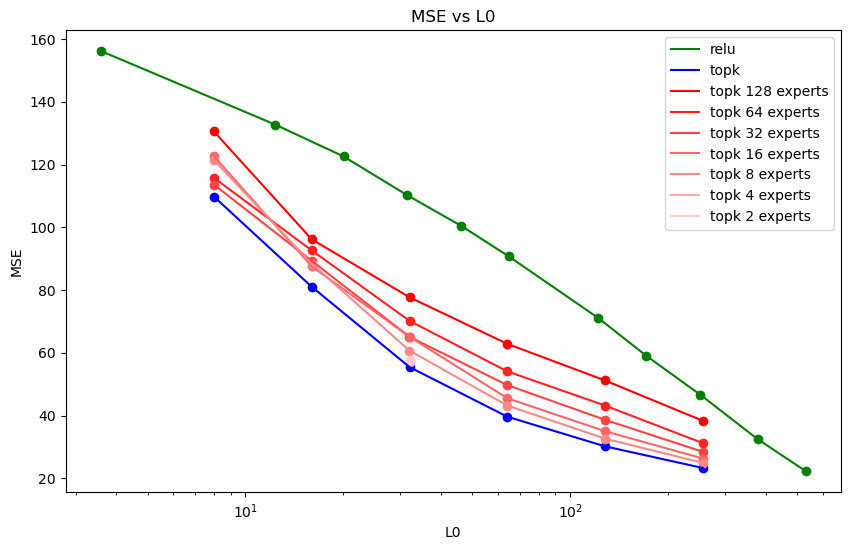

In [18]:
from matplotlib.colors import LinearSegmentedColormap
reds = LinearSegmentedColormap.from_list("grad_red", ["#ff0000", "#ffcccc"], N=len(switches))


plt.figure(figsize=(10, 6))
plt.plot(*to_sorted(relus), label='relu', color='green')
plt.scatter(*to_sorted(relus), color='green')

plt.plot(*to_sorted(topks), label='topk', color='blue')
plt.scatter(*to_sorted(topks), color='blue')


for i, (n_experts, switch) in enumerate(sorted(switches.items(), reverse=True)):
    color = reds(i / len(switches))  # Get a color from the colormap
    plt.plot(*to_sorted(switch), label=f'topk {n_experts} experts', color=color)
    plt.scatter(*to_sorted(switch), color=color)

# set title
plt.title("MSE vs L0")
plt.legend()
plt.xlabel("L0")
plt.ylabel("MSE")
plt.xscale('log')

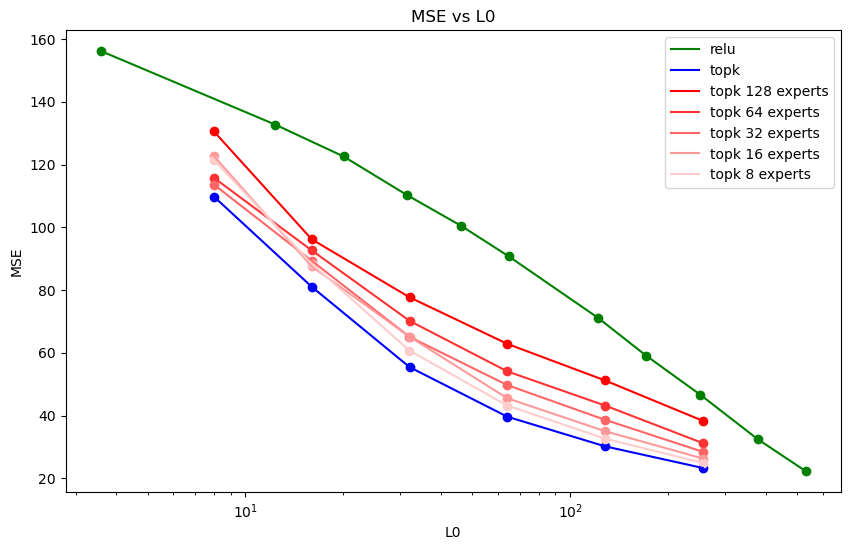

In [8]:
from matplotlib.colors import LinearSegmentedColormap
reds = LinearSegmentedColormap.from_list("grad_red", ["#ff0000", "#ffcccc"], N=len(switches))


plt.figure(figsize=(10, 6))
plt.plot(*to_sorted(relus), label='relu', color='green')
plt.scatter(*to_sorted(relus), color='green')

plt.plot(*to_sorted(topks), label='topk', color='blue')
plt.scatter(*to_sorted(topks), color='blue')


for i, (n_experts, switch) in enumerate(sorted(switches.items(), reverse=True)):
    color = reds(i / len(switches))  # Get a color from the colormap
    plt.plot(*to_sorted(switch), label=f'topk {n_experts} experts', color=color)
    plt.scatter(*to_sorted(switch), color=color)

# set title
plt.title("MSE vs L0")
plt.legend()
plt.xlabel("L0")
plt.ylabel("MSE")
plt.xscale('log')

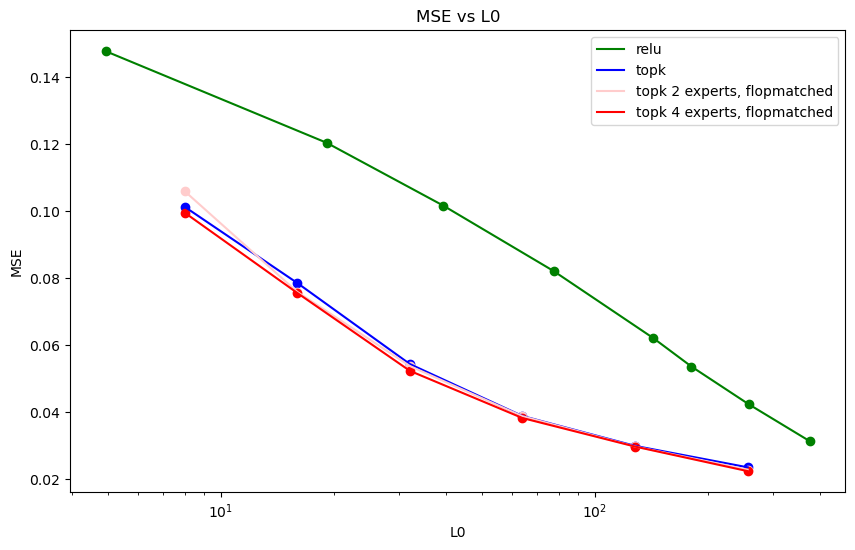

In [16]:

reds = LinearSegmentedColormap.from_list("grad_red", ["#ffcccc", "#ff0000"], N=len(flopswitches))

plt.figure(figsize=(10, 6))
plt.plot(*to_sorted(relus), label='relu', color='green')
plt.scatter(*to_sorted(relus), color='green')

plt.plot(*to_sorted(topks), label='topk', color='blue')
plt.scatter(*to_sorted(topks), color='blue')


for i, (n_experts, switch) in enumerate(sorted(flopswitches.items())):
    color = reds(i / len(flopswitches))  # Get a color from the colormap
    plt.plot(*to_sorted(switch), label=f'topk {n_experts} experts, flopmatched', color=color)
    plt.scatter(*to_sorted(switch), color=color)

# set title
plt.title("MSE vs L0")
plt.legend()
plt.xlabel("L0")
plt.ylabel("MSE")
plt.xscale('log')

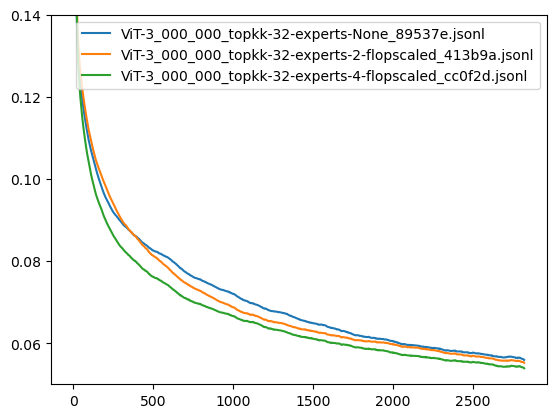

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

data = {}

for info in infos:
    # Your existing filtering conditions
    if info['architecture'] == 'topk' and info['n_experts'] is None:
        if info['k'] == 32:
            data[info['file']] = info['mse']

    if info['architecture'] == 'topk' and info['n_experts'] is not None:
        if info['k'] == 32:
            if info['n_feats'] == 65536:
                pass
            else:
                data[info['file']] = info['mse']

# Define a smoothing function (e.g., moving average)
def smooth(y, window_size):
    return np.convolve(y, np.ones(window_size)/window_size, mode='valid')

for key, values in data.items():
    values = np.array(values).tolist()
    # Apply smoothing to the values
    smoothed_values = smooth(values, window_size=100)
    # Adjust the x-axis to match the length of the smoothed data
    x_values = range(len(smoothed_values))
    plt.plot(x_values, smoothed_values, label=key)

plt.legend()
# plt.xscale('log')
plt.ylim(0.05, 0.14)
# plt.yscale('log')
plt.show()


In [110]:
files = []
for file in os.listdir(logdir):
    if file.startswith(prefix + 'kk32'):
        files.append(file)

infos = files_to_infos(logdir, files)

print(len(infos))

infos = [ i for i in infos if 'tokens_per_second' in i]

print(len(infos))

ViT-3_000_000_kk32-expansion-4-experts-4_f8b9a0.jsonl
ViT-3_000_000_kk32-expansion-16-experts-256_f620ca.jsonl
ViT-3_000_000_kk32-expansion-1-experts-4_325bc8.jsonl
ViT-3_000_000_kk32-expansion-1-experts-16_bad3b2.jsonl


ViT-3_000_000_kk32-expansion-4-experts-16_c67560.jsonl
ViT-3_000_000_kk32-expansion-1-experts-256_5be9fb.jsonl
ViT-3_000_000_kk32-baseline-8_19d744.jsonl
ViT-3_000_000_kk32-expansion-8-experts-4_27f34e.jsonl
ViT-3_000_000_kk32-expansion-16-experts-64_3cc508.jsonl
ViT-3_000_000_kk32-expansion-4-experts-64_f12731.jsonl
ViT-3_000_000_kk32-expansion-4-experts-256_fdf2da.jsonl
ViT-3_000_000_kk32-expansion-1-experts-64_da3f3b.jsonl
ViT-3_000_000_kk32-baseline-4_a84b18.jsonl
ViT-3_000_000_kk32-expansion-16-experts-4_3acf09.jsonl
ViT-3_000_000_kk32-expansion-32-experts-4_89d6d6.jsonl
ViT-3_000_000_kk32-expansion-32-experts-64_6aa623.jsonl
ViT-3_000_000_kk32-baseline-1_e50527.jsonl
ViT-3_000_000_kk32-expansion-32-experts-256_bf683a.jsonl
ViT-3_000_000_kk32-expansion-8-experts-64_c737a7.jsonl
ViT-3_000_000_kk32-expansion-16-experts-16_4c9010.jsonl
ViT-3_000_000_kk32-expansion-32-experts-16_6de78f.jsonl
ViT-3_000_000_kk32-baseline-16_d58820.jsonl
ViT-3_000_000_kk32-expansion-8-experts-16_ae76d1.j

In [111]:
n_experts = defaultdict(list)

for i in infos:
    e = i['n_experts']
    n_experts[e].append({
        'tokens_per_second': np.mean(i['tokens_per_second']),
        'file': i['file'],
        'inner_bs': i['inner_bs'],
        'torch.cuda.memory_allocated': np.mean(i['torch.cuda.memory_allocated'])
    })

/opt/conda/envs/pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


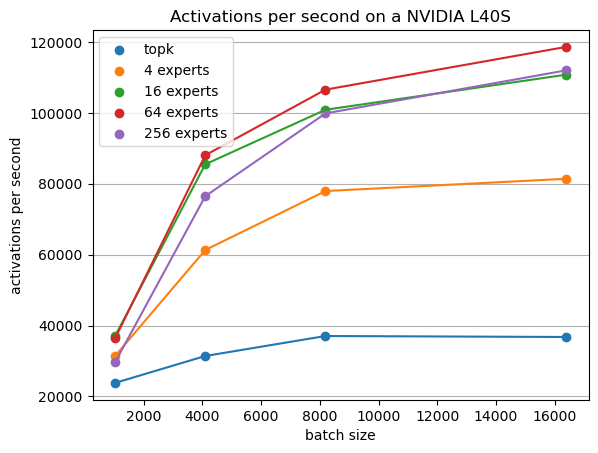

In [128]:
y_label = 'tokens_per_second'
for k, vals in sorted(n_experts.items(), key=lambda x: x[0] if x[0] is not None else 0):
    vals = sorted(vals, key=lambda x: x['inner_bs'])
    x = [v['inner_bs'] for v in vals]
    y = [v[y_label] for v in vals]

    
    es = "topk" if k is None else f'{k} experts'
    plt.scatter(x, y, label=es)
    plt.plot(x, y)

plt.legend()
plt.ylabel('activations per second')
plt.xlabel('batch size')
plt.title("Activations per second on a NVIDIA L40S")
plt.grid(axis='y')

In [134]:
n_experts[None][-1]

{'tokens_per_second': 36772.70015216348,
 'file': 'ViT-3_000_000_kk32-baseline-16_d58820.jsonl',
 'inner_bs': 16384,
 'torch.cuda.memory_allocated': 6368.6318359375}

In [135]:
118593 / 36772

3.2250897421951485